# Exploration of the Dynamic Solow Model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import copy
import matplotlib
import pickle
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

In [3]:
from solowModel2 import SolowModel
from phase_diagram import PhaseDiagram

In [4]:
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':16})
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)

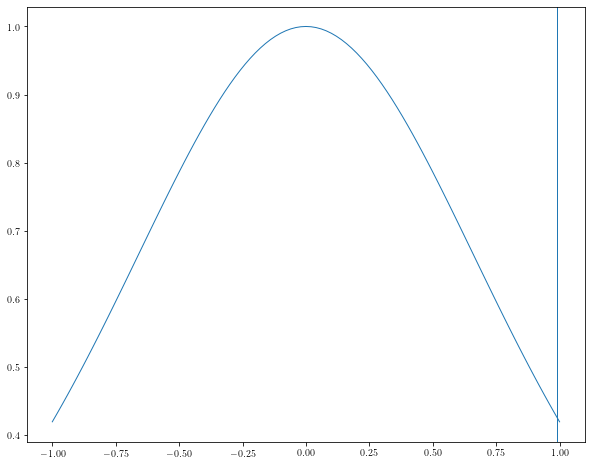

In [43]:
x = np.linspace(-1,1,101)
plt.plot(x, 1/(np.cosh(x)**2))
plt.axvline(0.99)
plt.show()

In [45]:
sech = lambda x: 1 / (np.cosh(x)**2)
print(sech(0.55))
print(sech(0.88))

0.7494795181900823
0.5009717437695083


## General Case

In [6]:
gamma = 1000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':2e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2/gamma, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

sm = SolowModel(params)

## Check the S-Bar condition

In [106]:
def f(x, b1):
    return np.arctanh(x)-(b1*x)

def case_kd(x, b2, gamma, c2, epsilon):
    return (b2*gamma*c2*x) + (b2*gamma*epsilon)

def case_ks(x, b2, gamma, c2, epsilon, rho):
    return (b2*gamma*epsilon)/(1-rho)

In [107]:
def intersect(func1, func2, args1, args2):
    # Determine intersections and thus long-term averages
    intersects = []
    for x0 in np.linspace(-.999, 0.999, 11):
        s = minimize(lambda x: np.sqrt((func1(x, *args1) - func2(x, *args2)) ** 2), x0=x0,
                     bounds=((-0.99, 0.99),), tol=1e-15)
        intersects.extend([s.x[0]])
    return [max(intersects), min(intersects)]

In [115]:
def approximation(s_bar, b1):
    constant = 0.5 * sum(s_bar)
    product = 0.5*sech(b1*s_bar[0]) + 0.5*sech(b1*s_bar[1])
    return [constant, product]

#### Variations in the Multiplier

In [157]:
g_vars = np.logspace(3,5,51)
c2_vars = np.logspace(-5,-3,51)
mult = np.empty((len(g_vars), len(c2_vars)))
cons = np.empty((len(g_vars), len(c2_vars)))

b1=1.1
b2=1.0
epsilon=1e-5

for i, gamma in enumerate(g_vars):
    for j, c2 in enumerate(c2_vars):
        sbar = intersect(f, case_kd, [1.1], [b2, gamma, c2, epsilon])
        cons[i,j], mult[i,j] = approximation(sbar, b1)

In [143]:
df_mult = pd.DataFrame(mult)
df_mult.columns = ["{:.1e}".format(c2) for c2 in c2_vars]
df_mult.index =["{:.1e}".format(g) for g in g_vars]

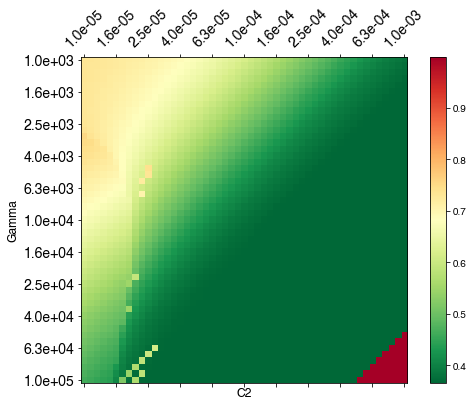

In [145]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
temp = ax.matshow(df_mult.values)
ax.set_ylabel("Gamma")
ax.set_xlabel("C2")
#ax.set_ylim(0,g_vars.max())
#ax.set_xlim(0,c2_vars.max())
ax.ticklabel_format(style='sci', axis='y', scilimits=(3, 5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-5, -3))
plt.xticks(range(q.shape[0]), q.columns, fontsize=14, rotation=45)
plt.yticks(range(q.shape[1]), q.index, fontsize=14)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_xticklabels(["{:.1e}".format(c2_vars[i]) for i in ax.get_xticks()])
ax.set_yticklabels(["{:.1e}".format(g_vars[i]) for i in ax.get_yticks()])
fig.colorbar(temp)
plt.show()

#### Variations in the Convergence/Divergence

In [181]:
# Params
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':2e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 4/(3*gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

# Variations in Gamma / C2
g_vars = np.logspace(3,5,51)
c2_vars = np.logspace(-5,-3,51)
grow_kd = np.empty((len(g_vars), len(c2_vars)))
grow_ks = np.empty((len(g_vars), len(c2_vars)))
criteria = np.empty((len(g_vars), len(c2_vars)))

for i,gamma in enumerate(g_vars):
    for j,c2 in enumerate(c2_vars):
        temp = mult[i,j]*params['beta2']*c2*gamma
        denom = 1 - params['rho']*temp
        
        grow_ks[i,j] = (params['epsilon'] + params['rho']*c2*cons[i,j]) / denom
        grow_kd[i,j] = c2*cons[i,j] + temp*grow_ks[i,j]

criteria = np.abs(grow_kd - grow_ks) < 1e-6

In [182]:
df_criteria = pd.DataFrame(criteria)
df_criteria.columns = ["{:.1e}".format(c2) for c2 in c2_vars]
df_criteria.index =["{:.1e}".format(g) for g in g_vars]

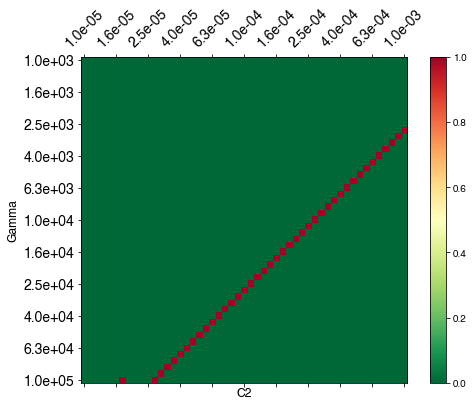

In [183]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
temp = ax.matshow(df_criteria.values)
ax.set_ylabel("Gamma")
ax.set_xlabel("C2")
#ax.set_ylim(0,g_vars.max())
#ax.set_xlim(0,c2_vars.max())
ax.ticklabel_format(style='sci', axis='y', scilimits=(3, 5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-5, -3))
plt.xticks(range(q.shape[0]), q.columns, fontsize=14, rotation=45)
plt.yticks(range(q.shape[1]), q.index, fontsize=14)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_xticklabels(["{:.1e}".format(c2_vars[i]) for i in ax.get_xticks()])
ax.set_yticklabels(["{:.1e}".format(g_vars[i]) for i in ax.get_yticks()])
fig.colorbar(temp)
plt.show()

In [214]:
# Params
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':2e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 4/(3*gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

# Variations in Gamma / C2
g_vars = np.logspace(3,5,51)
c2_vars = np.logspace(-5,-3,51)
grow_kd = np.empty((len(g_vars), len(c2_vars)))
grow_ks = np.empty((len(g_vars), len(c2_vars)))
criteria = np.empty((len(g_vars), len(c2_vars)))

for i,gamma in enumerate(g_vars):
    for j,c2 in enumerate(c2_vars):
        temp = mult[i,j]*params['beta2']*c2*gamma
        denom = 1 - params['rho']*temp
        
        grow_ks[i,j] = (params['epsilon']) / denom
        grow_kd[i,j] = c2*cons[i,j] + temp*grow_ks[i,j]

criteria = np.abs(grow_kd - grow_ks) < 1e-6

In [215]:
df_criteria = pd.DataFrame(criteria)
df_criteria.columns = ["{:.1e}".format(c2) for c2 in c2_vars]
df_criteria.index =["{:.1e}".format(g) for g in g_vars]

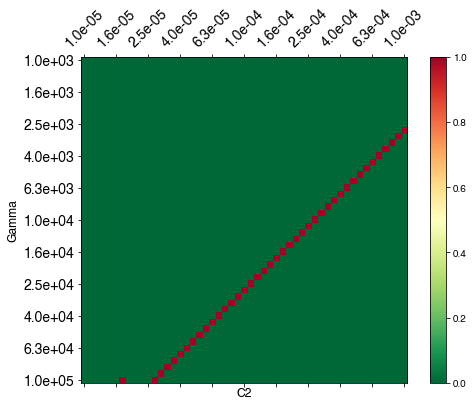

In [216]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
temp = ax.matshow(criteria)
ax.set_ylabel("Gamma")
ax.set_xlabel("C2")
#ax.set_ylim(0,g_vars.max())
#ax.set_xlim(0,c2_vars.max())
ax.ticklabel_format(style='sci', axis='y', scilimits=(3, 5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-5, -3))
plt.xticks(range(q.shape[0]), q.columns, fontsize=14, rotation=45)
plt.yticks(range(q.shape[1]), q.index, fontsize=14)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_xticklabels(["{:.1e}".format(c2_vars[i]) for i in ax.get_xticks()])
ax.set_yticklabels(["{:.1e}".format(g_vars[i]) for i in ax.get_yticks()])
fig.colorbar(temp)
plt.show()

In [217]:
indices = []
ratios = []
for i in range(df_criteria.shape[0]):
    for j in range(df_criteria.shape[1]):
        if df_criteria.iloc[i, j]:
            indices.append([g_vars[i], c2_vars[j]])
            ratios.extend([g_vars[i]*c2_vars[j]])

In [218]:
indices[0]

[2754.2287033381663, 0.001]

In [54]:
sm.analytics()

{'psi_y': 3.0000000000000004e-05,
 'psi_ks': 3.0000000000000004e-05,
 'psi_kd': 3.0000000000000004e-05,
 's_bar_top': 0.6912860057003432,
 's_bar_bottom': -0.301511347738697,
 'gamma_psi_y': (0.09, True),
 's_bar_cond': (0.02048122717815065, 0.09000000000000001, False)}

In [55]:
max_b1_11 = sm.analytics()['s_bar_cond'][0]
max_b1_11

0.02048122717815065

In [116]:
sbar_valid = sbar-max_b1_11<=0
non_div = div>1
mat = pd.DataFrame(div)
mat = mat[mat>1] # No divergence
mat = mat.mask(pd.DataFrame(sbar_valid)) # S-bar condition

In [118]:
q = pd.DataFrame(mat)
q.columns = ["{:.1e}".format(c2) for c2 in c2_vars]
q.index =["{:.1e}".format(g) for g in g_vars]
q

1.0e-05  1.1e-05  1.2e-05  1.3e-05  1.4e-05  1.6e-05   1.7e-05  \
1.0e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.1e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.2e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.3e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.4e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.6e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.7e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.9e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.1e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.3e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.5e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.8e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
3.0e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
3.3e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
3.6e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
4.0e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
4.4e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
4.8e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
5.2e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
5.8e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
6.3e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
6.9e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
7.6e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
8.3e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
9.1e+03      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.0e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.1e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.2e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.3e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.4e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.6e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.7e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
1.9e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.1e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.3e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.5e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
2.8e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
3.0e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
3.3e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
3.6e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
4.0e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
4.4e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
4.8e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
5.2e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
5.8e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
6.3e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
6.9e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
7.6e+04      NaN      NaN      NaN      NaN      NaN      NaN       NaN   
8.3e+04      NaN      NaN      NaN      NaN      NaN      NaN  1.084080   
9.1e+04      NaN      NaN      NaN      NaN      NaN  1.08408  1.188670   
1.0e+05      NaN      NaN      NaN      NaN  1.08408  1.18867  1.303351   

          1.9e-05   2.1e-05   2.3e-05  ...   4.4e-04   4.8e-04   5.2e-04  \
1.0e+03       NaN       NaN     

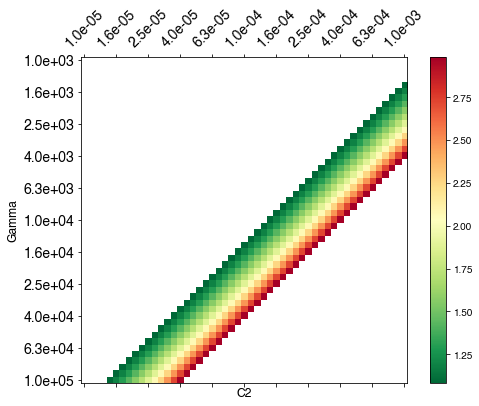

In [119]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)
temp = ax.matshow(q.values)
ax.set_ylabel("Gamma")
ax.set_xlabel("C2")
#ax.set_ylim(0,g_vars.max())
#ax.set_xlim(0,c2_vars.max())
ax.ticklabel_format(style='sci', axis='y', scilimits=(3, 5))
ax.ticklabel_format(style='sci', axis='x', scilimits=(-5, -3))
plt.xticks(range(q.shape[0]), q.columns, fontsize=14, rotation=45)
plt.yticks(range(q.shape[1]), q.index, fontsize=14)
ax.set_xticks(ax.get_xticks()[::5])
ax.set_yticks(ax.get_yticks()[::5])
ax.set_xticklabels(["{:.1e}".format(c2_vars[i]) for i in ax.get_xticks()])
ax.set_yticklabels(["{:.1e}".format(g_vars[i]) for i in ax.get_yticks()])
fig.colorbar(temp)
plt.show()

## S-Bar Solution

In [5]:
gamma = 3000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':2e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 4/(3*gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

sm = SolowModel(params)

In [49]:
def f(x, b1):
    return np.arctanh(x)-(b1*x)

def case_kd(x, b2, gamma, c2, epsilon):
    return (b2*gamma*c2*x) + (b2*gamma*epsilon)

def case_ks(x, b2, gamma, c2, epsilon, rho):
    return (b2*gamma*epsilon)/(1-rho)

In [52]:
def intersect(func1, func2, args1, args2):
    # Determine intersections and thus long-term averages
    intersects = []
    for x0 in np.linspace(-.999, 0.999, 11):
        s = minimize(lambda x: np.sqrt((func1(x, *args1) - func2(x, *args2)) ** 2), x0=x0,
                     bounds=((-0.99, 0.99),), tol=1e-15)
        intersects.extend([s.x[0]])
    return [max(intersects), min(intersects)]

In [100]:
gamma = 1000
c2 = 1e-4
epsilon = 1e-5
b2 = 1.0

params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2*(1/gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}



kd = intersect(f, case_kd, [1.1], [b2, gamma, c2, epsilon])
ks = intersect(f, case_ks, [1.1], [b2, gamma, c2, epsilon, 1/3])
print(kd, ks)
print([sech(i) for i in kd])

[0.6752013851701539, -0.6396476578993604] [0.5547730441612597, -0.41372790346950505]
[0.6537961054451304, 0.6811595367900383]


In [ ]:
gamma = 1000
c2 = 2/1000
epsilon = 1e-5
b2 = 1.0

params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':1000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2*(1/gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}



kd = intersect(f, case_kd, [1.1], [b2, gamma, c2, epsilon])
ks = intersect(f, case_ks, [1.1], [b2, gamma, c2, epsilon, 1/3])
print(kd, ks)
print([sech(i) for i in kd])

In [141]:
gamma = 1000
c2 = 1e-4
epsilon = 1e-5 
b2 = 1.0

kd = intersect(f, case_kd, [1.1], [b2, gamma, c2, epsilon])
ks = intersect(f, case_ks, [1.1], [b2, gamma, c2, epsilon, 1/3])
print(kd, ks)
print("c2 should be {:.3e}")

[0.6752013851701539, -0.6396476578993604] [0.5547730441612597, -0.41372790346950505]
c2 should be {:.3e}


In [103]:
gamma = 10000
c2 = 1e-5
epsilon = 1e-5 
b2 = 1.0

kd = intersect(f, case_kd, [1.1], [b2, gamma, c2, epsilon])
ks = intersect(f, case_ks, [1.1], [b2, gamma, c2, epsilon, 1/3])
print(kd, ks)
print([sech(i) for i in kd])

[0.7728916400437845, -0.40824828746182446] [0.751714868214717, -0.301511347738697]
[0.5793079948565856, 0.8502431445053392]


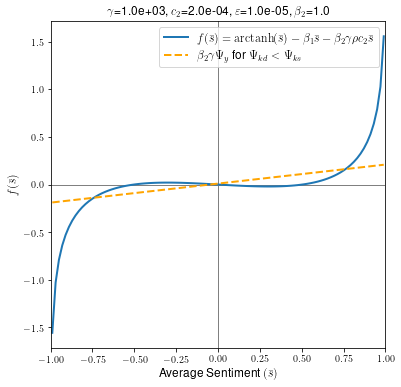

In [96]:
gamma = 1000
c2 = 2e-4
epsilon = 1e-5 
b2 = 1.0

plt.rc('text', usetex=True)
x = np.linspace(-0.99, 0.99, 101)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6,6)

ax.axhline(0, color='gray')
ax.axvline(0, color='gray')

ax.plot(x, f(x, 1.1), linewidth=2, label=r'$f(\bar{s})=\textrm{arctanh}(\bar{s})-\beta_1\bar{s}-\beta_2\gamma\rho c_2\bar{s}$')
ax.plot(x, case_kd(x, b2, gamma, c2, epsilon), color='orange', linestyle='--', linewidth=2, label=r'$\beta_2\gamma\Psi_y$ for $\Psi_{kd}<\Psi_{ks}$')
#ax.axhline(case_ks(1, b2, gamma, c2, epsilon, 1/3), color='green', linestyle='--', linewidth=2, label=r'$\beta_2\gamma\Psi_y$ for $\Psi_{kd}>\Psi_{ks}$')

ax.set_xlim(-1,1)

ax.set_title(r'$\gamma$={:.1e}, $c_2$={:.1e}, $\varepsilon$={:.1e}, $\beta_2$={:.1f}'.format(gamma, c2, epsilon, b2))

ax.set_xlabel(r'Average Sentiment $(\bar{s})$')
ax.set_ylabel(r'$f(\bar{s})$')
ax.legend()
plt.show()

The solver successfully reached the end of the integration interval.
{'psi_y': 1.8214936247723136e-05, 'psi_ks': 1.8214936247723136e-05, 'psi_kd': 2.4644808743169405e-05, 's_bar_top': 0.788668667593977, 's_bar_bottom': -0.301511347738697, 'gamma_psi_y': (0.20036429872495448, True), 's_bar_cond': (0.02048122717815065, 0.2003642987249545, False)}


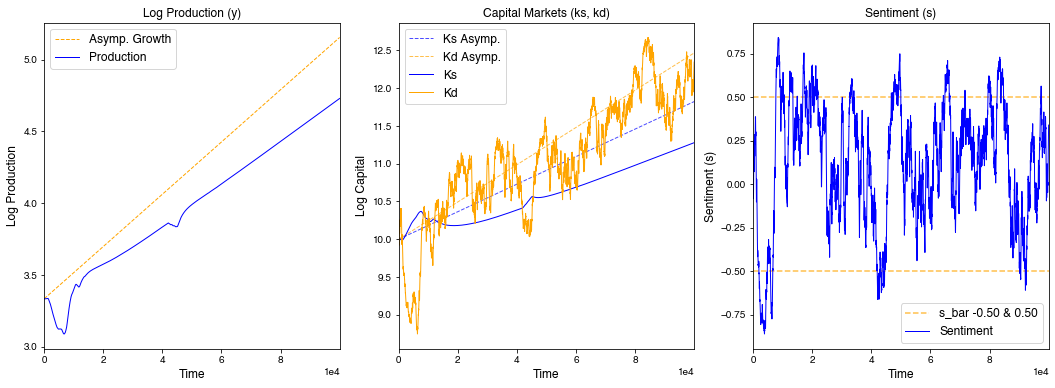

In [86]:
gamma = 11000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 0.000164, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.5))
path = sm.solve(start, t_end=1e5, seed=40, case='general', save=False)
print(sm.analytics())
sm.overview()

## Unbounded Information Case

#### Seed 40

The solver successfully reached the end of the integration interval.
{'psi_y': 1.8214936247723136e-05, 'psi_ks': 1.8214936247723136e-05, 'psi_kd': 2.4644808743169405e-05, 's_bar_top': 0.788668667593977, 's_bar_bottom': -0.301511347738697, 'gamma_psi_y': (0.20036429872495448, True), 's_bar_cond': (0.02048122717815065, 0.2003642987249545, False)}


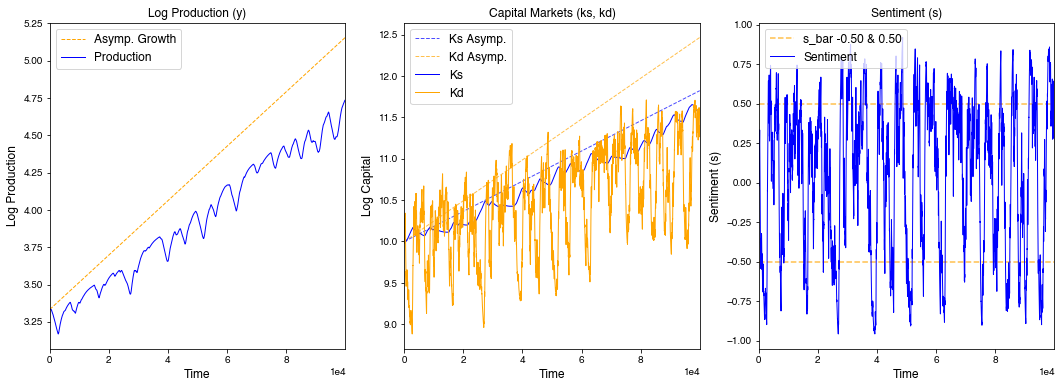

In [225]:
gamma = 11000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 0.000164, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm.solve(start, t_end=1e5, seed=40, case='unbounded_information', save=True)
print(sm.analytics())
sm.overview()

In [223]:
gamma = 11000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 0.000164, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 9, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm1 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm1.solve(start, t_end=1e5, seed=40, case='general', save=True)
print(sm1.analytics())
sm1.overview()

KeyboardInterrupt: 

#### Seed 50

The solver successfully reached the end of the integration interval.
{'psi_y': 3.2000000000000005e-05, 'psi_ks': 3.2000000000000005e-05, 'psi_kd': 6.6e-05, 's_bar_top': 0.6557567061476313, 's_bar_bottom': -0.301511347738697, 'gamma_psi_y': (0.06399999999999997, True), 's_bar_cond': (0.02048122717815065, 0.06400000000000002, False)}


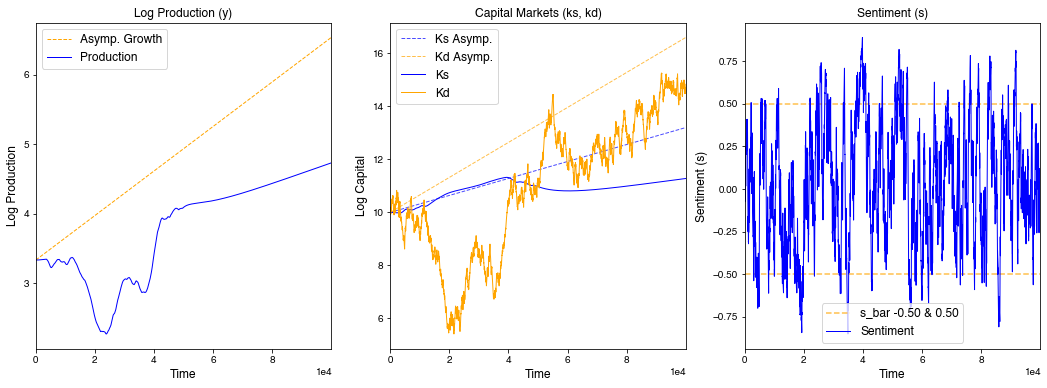

In [210]:
gamma = 2000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2.75*(1/gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm.solve(start, t_end=1e5, seed=50, case='unbounded_information', save=True)
print(sm.analytics())
sm.overview()

The solver successfully reached the end of the integration interval.
{'psi_y': 3.2000000000000005e-05, 'psi_ks': 3.2000000000000005e-05, 'psi_kd': 6.6e-05, 's_bar_top': 0.5974999001693074, 's_bar_bottom': -0.30151134659774637, 'gamma_psi_y': (0.03199999999999999, True), 's_bar_cond': (0.02048122717815065, 0.03200000000000001, False)}


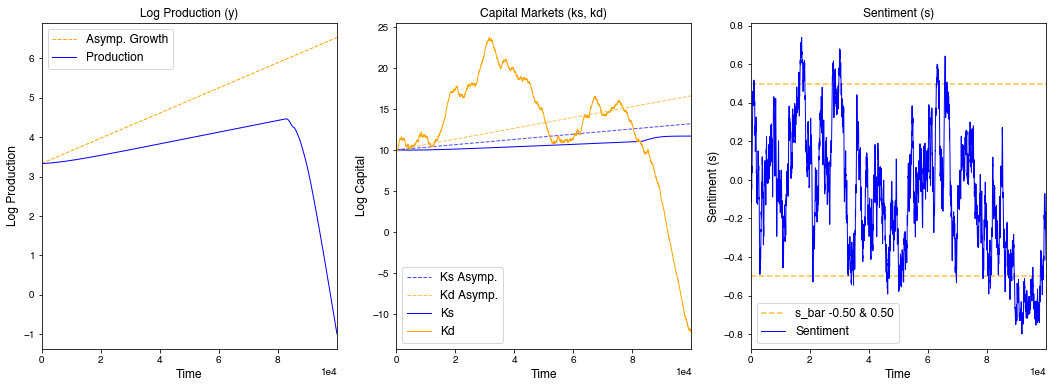

In [211]:
gamma = 1000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2.75*(1/gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm1 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm1.solve(start, t_end=1e5, seed=50, case='general', save=True)
print(sm1.analytics())
sm1.overview()

#### Seed 40 - Gamma 2e3

Unbounded Information Case

The solver successfully reached the end of the integration interval.
{'psi_y': 2.5e-05, 'psi_ks': 2.5e-05, 'psi_kd': 4.4999999999999996e-05, 's_bar_top': 0.751714868214717, 's_bar_bottom': -0.301511347738697, 'gamma_psi_y': (0.15000000000000005, True), 's_bar_cond': (0.02048122717815065, 0.15, False)}


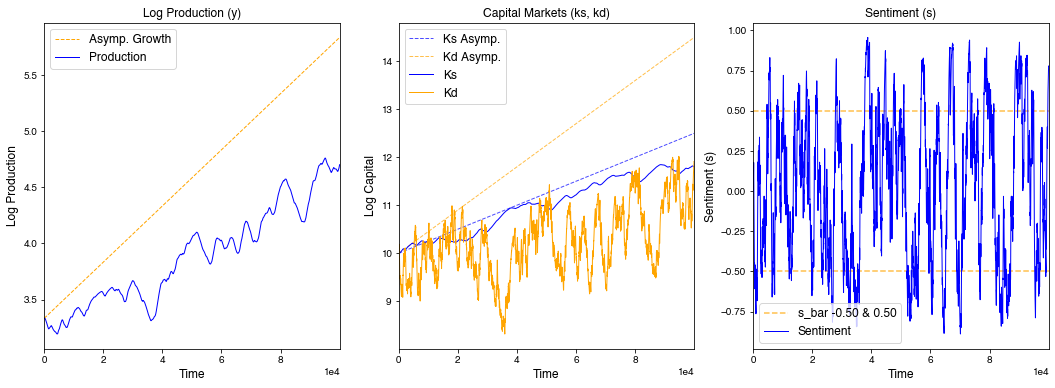

In [150]:
gamma = 6000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 4e-4, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm.solve(start, t_end=1e5, seed=47, case='unbounded_information', save=True)
print(sm.analytics())
sm.overview()

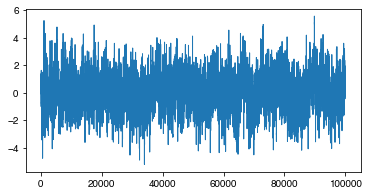

In [158]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm.path.h)
plt.show()

General Case

The solver successfully reached the end of the integration interval.
{'psi_y': 2.5e-05, 'psi_ks': 2.5e-05, 'psi_kd': 4.4999999999999996e-05, 's_bar_top': 0.751714868214717, 's_bar_bottom': -0.301511347738697, 'gamma_psi_y': (0.15000000000000005, True), 's_bar_cond': (0.02048122717815065, 0.15, False)}


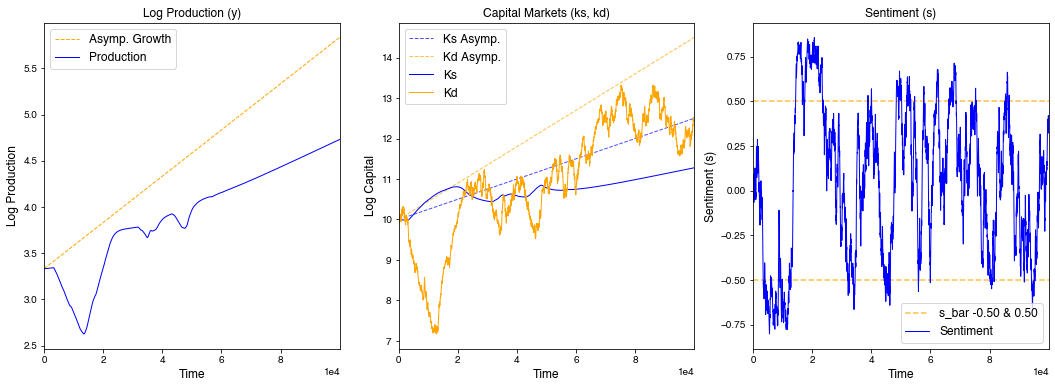

In [151]:
gamma = 6000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 4e-4, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm1 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm1.solve(start, t_end=1e5, seed=45, case='general', save=True)
print(sm1.analytics())
sm1.overview()

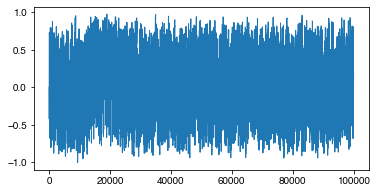

In [159]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm1.path.h)
plt.show()

#### Seed 50 - Gamma 2e3

The solver successfully reached the end of the integration interval.
{'psi_y': 1.5000000000000002e-05, 'psi_ks': 1.5000000000000002e-05, 'psi_kd': 1.5000000000000002e-05, 's_bar_top': 0.6237595446598544, 's_bar_bottom': -0.30151134659774637, 'gamma_psi_y': (0.045, True), 's_bar_cond': (0.02048122717815065, 0.045000000000000005, False)}


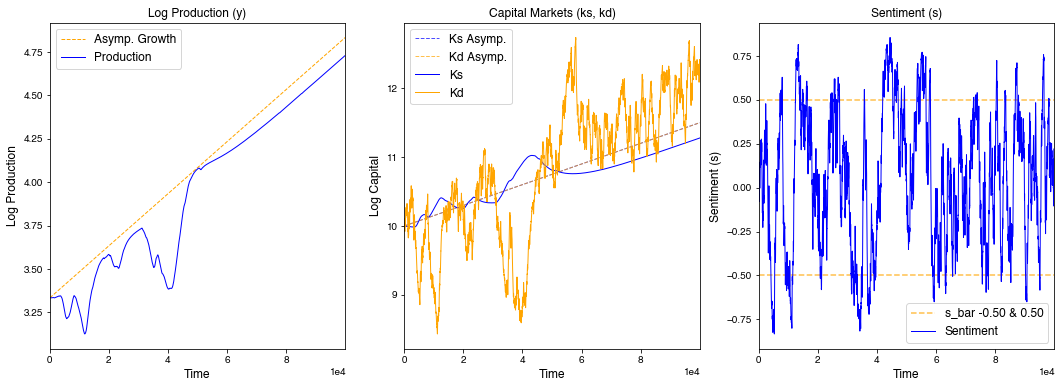

In [125]:
gamma = 3000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 4/(3*gamma), "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params, xi_args=dict(decay=0.2, diffusion=1.0))
path = sm.solve(start, t_end=1e5, seed=50, case='unbounded_information', save=True)
print(sm.analytics())
sm.overview()

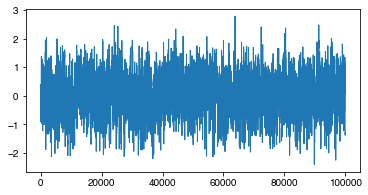

In [130]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm.path.h)
plt.show()

In [ ]:
gamma = 3000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2.75/gamma, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm1 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=1.0))
path = sm1.solve(start, t_end=1e5, seed=50, case='general', save=True)
print(sm1.analytics())
sm1.overview()

In [ ]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm1.path.h)
plt.show()

#### Seed 60 - Gamma 2e3

The solver successfully reached the end of the integration interval.
{'psi_y': 3.2000000000000005e-05, 'psi_ks': 3.2000000000000005e-05, 'psi_kd': 6.6e-05, 's_bar_top': 0.6984819561816131, 's_bar_bottom': -0.301511347738697, 'gamma_psi_y': (0.096, True), 's_bar_cond': (0.02048122717815065, 0.09600000000000002, False)}


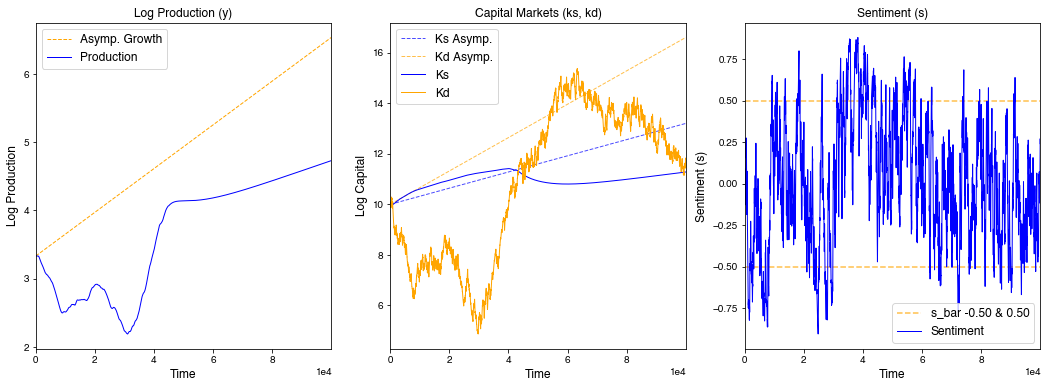

In [198]:
gamma = 3000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2.75/gamma, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm.solve(start, t_end=1e5, seed=60, case='unbounded_information', save=True)
print(sm.analytics())
sm.overview()

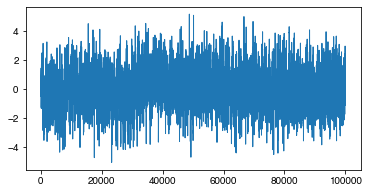

In [199]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm.path.h)
plt.show()

The solver successfully reached the end of the integration interval.
{'psi_y': 3.2000000000000005e-05, 'psi_ks': 3.2000000000000005e-05, 'psi_kd': 6.6e-05, 's_bar_top': 0.6984819561816131, 's_bar_bottom': -0.301511347738697, 'gamma_psi_y': (0.096, True), 's_bar_cond': (0.02048122717815065, 0.09600000000000002, False)}


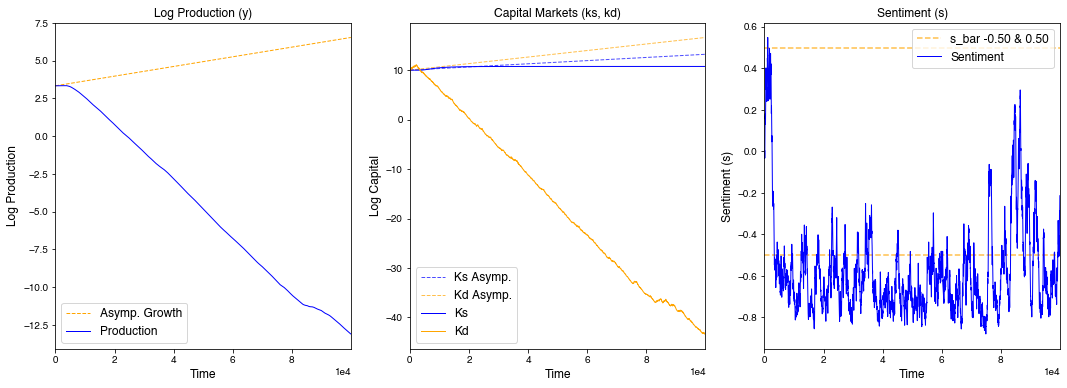

In [200]:
gamma = 3000
params = {
    'tech0':np.exp(1), 'rho':1/3, 'epsilon':1e-5, 'tau_y':2000, 'dep':0.0002,
    "tau_h" : 25, "tau_s" : 250, "c1" : 1, "c2" : 2.75/gamma, "gamma":gamma,
    "beta1" : 1.1, "beta2" : 1.0, 'saving0':0.15, "s0" : 0, "h_h":10
}

start = np.array([1, 10, 10, 0, 0, 1, params['saving0']])
start[0] = params['epsilon'] + params['rho'] * min(start[1:3])

sm1 = SolowModel(params, xi_args=dict(decay=0.2, diffusion=2.0))
path = sm1.solve(start, t_end=1e5, seed=60, case='general', save=True)
print(sm1.analytics())
sm1.overview()

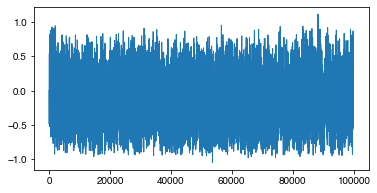

In [201]:
fig = plt.figure()
fig.set_size_inches(6,3)
plt.plot(sm1.path.h)
plt.show()

In [197]:
temp1 = intersect(f, case_kd, [1.1], [1.0, gamma, 2.75/3000, params['epsilon']])
temp2 = intersect(f, case_ks, [1.1], [1.0, gamma, 2.75/3000, params['epsilon'], 1/3])
print(temp1, temp2)

[0.99, -0.99] [0.6237595438340131, -0.30151134659774637]


## Empirical Data For Parameters

### Savings Rate
Taking the macro approach => savings rate is roughly equal to the gdp divided by the real investment

In [43]:
gdp = pd.read_csv('GDPC1.csv')
gdp.set_index('DATE', inplace=True)
df = pd.DataFrame(gdp)
df.columns = ['gdp']

investment = pd.read_csv('GPDIC1.csv')
investment.set_index('DATE', inplace=True)
df.loc[:,'investment'] = investment
df.loc[:,'saving'] = df.investment / df.gdp

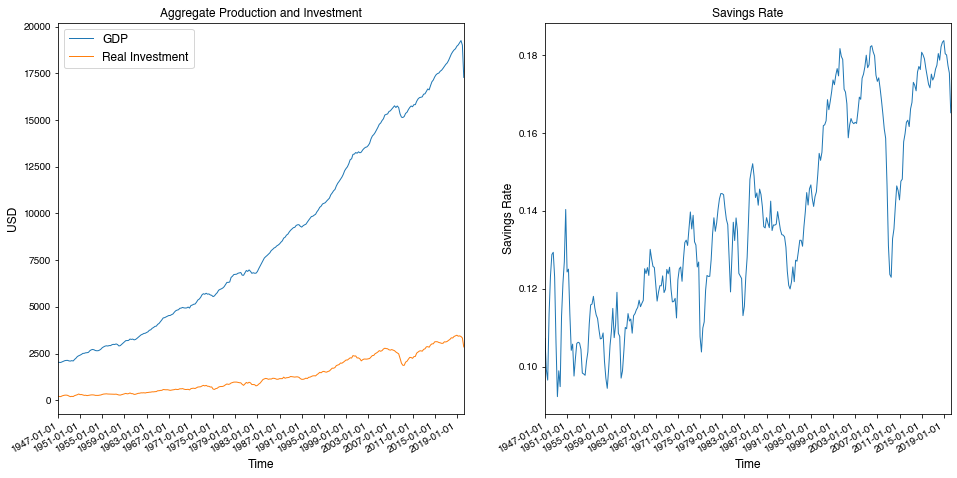

In [94]:
import matplotlib.dates as mdates
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16,8)

ax[0].plot(df.gdp, label='GDP')
ax[0].plot(df.investment, label='Real Investment')
ax[0].set_title('Aggregate Production and Investment')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('USD')
ax[0].legend()
ax[0].set_xlim(df.index[0], df.index[-1])
ax[0].set_xticks(ax[0].get_xticks()[::16])

ax[1].plot(df.saving, label='Savings Rate')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Savings Rate')
ax[1].set_title('Savings Rate')
ax[1].set_xticks(ax[1].get_xticks()[::16])
ax[1].set_xlim(df.index[0], df.index[-1])
fig.autofmt_xdate()
plt.show()